In [1]:
import os
import pandas as pd
import numpy as np
import json
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import ast

In [2]:
question_path = "../dataset/questions/WV7_English.jsonl"

In [3]:
question_list = []
with open(question_path, 'r', encoding='utf-8') as f:
    for line in f:
        l = json.loads(line)
        if l['type'] == 'Opinion-Dependent':
            question_list.append(l)

In [4]:
hm_data_path = "../dataset/wvs/WV7.csv"
hm_df = pd.read_csv(hm_data_path)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/wvs/WV7.csv'

In [ ]:
country_path = "../dataset/country_12.jsonl"
json_file = open(country_path)
country_dict = json.load(json_file)

In [ ]:
filtered_country_dict = dict()
for ckey, cvalue in country_dict.items():
    country_df = hm_df[hm_df['B_COUNTRY'] == int(ckey)]
    if country_df.empty == False:
        filtered_country_dict[ckey] = cvalue

In [ ]:
filtered_country_dict['DeepSeek-R1'] = 'DeepSeek-R1'
countries = list(filtered_country_dict.keys())

In [ ]:
n_countries = len(countries)
alignment_matrix = np.zeros((n_countries, n_countries))

In [ ]:
def load_llm_question_probs_list(llm_name):
    if llm_name == 'DeepSeek-R1':
        llm_name = 'deepseek-reasoner'
    
    llm_path = f"../results/RQ1/{llm_name}/results.csv"
    llm_df = pd.read_csv(llm_path)

    question_dict = dict()
    for question in question_list:
        id = question['id']
        choice_keys = question['choice_keys']
        q_df = llm_df[llm_df['id']== id]
        if q_df.empty:
            continue
        response = q_df['response'].values[0]
        probs = ast.literal_eval(response)
        probs = [float(v.strip('%')) / 100 for k, v in probs.items()]
        question_dict[id] = probs
    
    return question_dict

In [ ]:
def load_country_question_probs_list(hm_df, country_code):
    countryquestion_dict = dict()
    country_code = int(country_code)
    country_df = hm_df[hm_df['B_COUNTRY'] == country_code]
    for question in question_list:
        distribution_of_question_dict = dict()
        id = question['id']
        choice_keys = question['choice_keys']
        
        question_df = country_df[id]

        for choice_key in choice_keys:
            choice_count = len(question_df[question_df == int(choice_key)])
            distribution_of_question_dict[choice_key] = choice_count
        if sum(distribution_of_question_dict.values()) == 0:
            continue
        distribution_of_question_dict = [v/sum(distribution_of_question_dict.values()) for k,v in distribution_of_question_dict.items()]
        countryquestion_dict[id] = distribution_of_question_dict
    return countryquestion_dict

In [ ]:
def alignment_score(D1, D2):
    scores = []
    for p1, p2 in zip(D1, D2):
        if len(p1) != len(p2):
            continue
        N = len(p1)
        support = np.arange(1, N + 1)
        wd = wasserstein_distance(support, support, p1, p2)
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4).item()

In [ ]:
def calculate_alignment_score_by_question_list(country_i_question_probs_list, country_j_question_probs_list):
    alignment_score_of_country_i_j = alignment_score(country_i_question_probs_list, country_j_question_probs_list)
    return alignment_score_of_country_i_j

In [ ]:
for i, ki in enumerate(countries):
    if ki == 'DeepSeek-R1':
        country_i_question_probs_dict = load_llm_question_probs_list(ki)
    else:
        country_i_question_probs_dict = load_country_question_probs_list(hm_df, ki)
    
    for j, kj in enumerate(countries):
        if kj == 'DeepSeek-R1':
            country_j_question_probs_dict = load_llm_question_probs_list(kj)
        else:
            country_j_question_probs_dict = load_country_question_probs_list(hm_df, kj)
        
        common_question_ids = set(country_i_question_probs_dict.keys()) & set(country_j_question_probs_dict.keys())
        country_i_question_probs_list = [country_i_question_probs_dict[qid] for qid in common_question_ids]
        country_j_question_probs_list = [country_j_question_probs_dict[qid] for qid in common_question_ids]
        alignment_matrix[i, j] = calculate_alignment_score_by_question_list(
            country_i_question_probs_list,
            country_j_question_probs_list,
        )


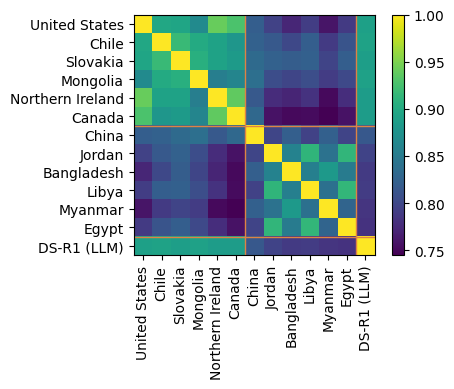

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(alignment_matrix)
ax.set_xticks(np.arange(n_countries))
ax.set_yticks(np.arange(n_countries))
country_labels = [filtered_country_dict[str(k)] for k in countries]
for i in country_labels:
    if i == 'DeepSeek-R1':
        country_labels[country_labels.index(i)] = 'DS-R1 (LLM)'
ax.set_xticklabels(country_labels, rotation=90)
ax.set_yticklabels(country_labels)

line_idx_list = [6, 12]
line_color = '#DE8344'

for line_idx in line_idx_list:
    ax.axhline(line_idx - 0.5, color=line_color, linewidth=1.0)
    ax.axvline(line_idx - 0.5, color=line_color, linewidth=1.0)
fig.colorbar(cax)
plt.tight_layout()
plt.savefig("../figures/SM/human_performance.pdf")